In [129]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc


In [130]:
# Load the data from CSV file
df = pd.read_csv("bankruptcy.csv")
# df.head()

# Check for NaN Values
nan_rows = df[df.isna().any(axis=1)]
if len(nan_rows) > 0:
    print(nan_rows)
else:
    print("No NaN values found.")

No NaN values found.


### We will split the data into two different groups. The first dataframe will contain all 95 variables while the second dataframe will contain the top 10 variables with the highest correlation to bankruptcy. 

### The cell below is for all variables

In [131]:
# Split the data into training and testing sets for all variables
X = df.drop("Bankrupt?", axis=1)
y = df["Bankrupt?"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

y.value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

### The cell below upsamples all the data to give us a more even distribution of data

In [132]:
# Separate majority and minority classes
df_majority = df[df["Bankrupt?"] == 0]
df_minority = df[df["Bankrupt?"] == 1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42)  # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled["Bankrupt?"].value_counts()
X_upsample = df_upsampled.drop("Bankrupt?", axis=1)
y_upsample = df_upsampled["Bankrupt?"]

X_train_upsample, X_test_upsample, y_train_upsample, y_test_upsample = train_test_split(X_upsample, y_upsample, test_size=0.2,random_state=42)
y_upsample.value_counts()



0    6599
1    6599
Name: Bankrupt?, dtype: int64

### The cell below gives us the dataframe containing the top 10 variables with the highes correlation to bankruptcy

In [133]:
# Split the data into training and testing sets for top 10 variables based on correlation with bankruptcy

corr_matrix = df_upsampled.corr()
num_features = 10
corr_with_bankrupt = corr_matrix["Bankrupt?"].abs().sort_values(ascending=False)
top_corr_features = corr_with_bankrupt[1:num_features+1].index.tolist()
df_top10_upsampled = df_upsampled[top_corr_features]
X_top10_upsample = df_top10_upsampled
y_top10_upsample = df_upsampled["Bankrupt?"]
X_train_top10_upsample, X_test_top10_upsample, y_train_top10_upsample, y_test_top10_upsample = train_test_split(X_top10_upsample, y_top10_upsample, test_size=0.2,random_state=42)

### Building a Neural Network Model

### Overall, this model architecture consists of three fully connected layers with ReLU activation functions, followed by BatchNormalization and Dropout layers to improve model performance and prevent overfitting, and a final output layer with a sigmoid activation function for binary classification.

In [134]:
# Build the neural network model


# model for upsampled data (All)

model_upsample_all = Sequential()
model_upsample_all.add(Dense(128, input_dim=X_train_upsample.shape[1], activation='relu'))
model_upsample_all.add(BatchNormalization())
model_upsample_all.add(Dense(64, activation='relu'))
model_upsample_all.add(Dropout(0.2))
model_upsample_all.add(Dense(32, activation='relu'))
model_upsample_all.add(Dense(1, activation='sigmoid'))
model_upsample_all.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



# model for upsampled data (Top 10)

model_upsample_top10 = Sequential()
model_upsample_top10.add(Dense(128, input_dim=X_train_top10_upsample.shape[1], activation='relu'))
model_upsample_top10.add(BatchNormalization())
model_upsample_top10.add(Dense(64, activation='relu'))
model_upsample_top10.add(Dropout(0.2))
model_upsample_top10.add(Dense(32, activation='relu'))
model_upsample_top10.add(Dense(1, activation='sigmoid'))
model_upsample_top10.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



### model.compile is a function in Keras that compiles the model with the chosen loss function, optimizer, and metrics. In this case, the loss function chosen is binary_crossentropy, which is commonly used for binary classification problems. The optimizer chosen is adam, which is a commonly used optimization algorithm for neural networks. Finally, metrics is set to accuracy, which will be used to evaluate the performance of the model during training and testing.

In [135]:

# compile the model for all variables with upsampled dataset

model_upsample_all.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# compile the model for top 10 variables with upsampled dataset

model_upsample_top10.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


### This line of code trains the neural network model on the training data with the following parameters:

### Overall, this line of code is training the neural network model on the upsampled training data, using mini-batch stochastic gradient descent with a batch size of 32 and the binary crossentropy loss function. The model is evaluated on the validation data after each epoch.

In [136]:
# Train the model for all the variables with the upsampled dataset

model_upsample_all.fit(X_train_upsample, y_train_upsample, epochs=50, batch_size=32, validation_data=(X_test_upsample, y_test_upsample))

# Train the model for top 10 variables with the upsampled dataset

model_upsample_top10.fit(X_train_top10_upsample, y_train_top10_upsample, epochs=50, batch_size=32, validation_data=(X_test_top10_upsample, y_test_top10_upsample))



Epoch 1/50
330/330 [==============================] - 2s 2ms/step - loss: 0.5798 - accuracy: 0.6871 - val_loss: 0.4858 - val_accuracy: 0.7530
Epoch 2/50
330/330 [==============================] - 0s 1ms/step - loss: 0.4778 - accuracy: 0.7722 - val_loss: 0.4203 - val_accuracy: 0.8019
Epoch 3/50
330/330 [==============================] - 1s 2ms/step - loss: 0.4356 - accuracy: 0.7938 - val_loss: 0.3924 - val_accuracy: 0.8201
Epoch 4/50
330/330 [==============================] - 1s 2ms/step - loss: 0.4134 - accuracy: 0.8106 - val_loss: 0.3732 - val_accuracy: 0.8348
Epoch 5/50
330/330 [==============================] - 0s 1ms/step - loss: 0.3925 - accuracy: 0.8252 - val_loss: 0.3451 - val_accuracy: 0.8663
Epoch 6/50
330/330 [==============================] - 1s 2ms/step - loss: 0.3819 - accuracy: 0.8301 - val_loss: 0.3304 - val_accuracy: 0.8629
Epoch 7/50
330/330 [==============================] - 1s 2ms/step - loss: 0.3701 - accuracy: 0.8392 - val_loss: 0.3037 - val_accuracy: 0.8784
Epoch 

### Seeing the accuracy of our NN model(s)

### We will now output the accuracy for our NN models

In [137]:

#Accuracy for upsampled dataset for all the variables and optimised model
loss_upsample_all, accuracy_upsample_all = model_upsample_all.evaluate(X_test_upsample, y_test_upsample)

print("Accuracy for upsampled dataset with all variables:", accuracy_upsample_all)


#Accuracy for upsampled dataset for top 10 variables and optimised model
loss_upsample_top10, accuracy_upsample_top10 = model_upsample_top10.evaluate(X_test_top10_upsample, y_test_top10_upsample)

print("Accuracy for upsampled dataset with top 10 variables:", accuracy_upsample_top10)

83/83 [==============================] - 0s 1ms/step - loss: 0.1455 - accuracy: 0.9405
Accuracy for upsampled dataset with all variables: 0.9405303001403809
83/83 [==============================] - 0s 946us/step - loss: 0.4761 - accuracy: 0.8341
Accuracy for upsampled dataset with top 10 variables: 0.8340908885002136


### Data visualisation for ML models


### Building a Decision Tree Model For All Variables

### This code trains a decision tree classifier model dectree with a maximum depth of 2 on the training data X_train_upsample and y_train_upsample.

### After training, the model is visualized as a tree using the plot_tree function from sklearn.tree. The plot_tree function generates a tree diagram that shows the decision-making process of the decision tree model.

### The filled=True argument fills the tree nodes with colors to indicate the class distribution, while the rounded=True argument makes the edges of the boxes around the nodes rounded.

### The feature_names argument specifies the names of the input features or predictors, which are columns in the DataFrame X.

### The class_names argument specifies the names of the target classes or outputs, which in this case are "Not Bankrupt" and "Bankrupt".

### The resulting tree diagram can be used to interpret how the model makes predictions for new data based on the values of the input features.

[Text(0.5, 0.8333333333333334, ' Continuous interest rate (after tax) <= 0.782\ngini = 0.5\nsamples = 10558\nvalue = [5271, 5287]\nclass = Bankrupt'),
 Text(0.25, 0.5, ' Total debt/Total net worth <= 0.01\ngini = 0.334\nsamples = 5717\nvalue = [1212, 4505]\nclass = Bankrupt'),
 Text(0.125, 0.16666666666666666, 'gini = 0.499\nsamples = 1616\nvalue = [852, 764]\nclass = Not Bankrupt'),
 Text(0.375, 0.16666666666666666, 'gini = 0.16\nsamples = 4101\nvalue = [360, 3741]\nclass = Bankrupt'),
 Text(0.75, 0.5, ' Interest Expense Ratio <= 0.632\ngini = 0.271\nsamples = 4841\nvalue = [4059, 782]\nclass = Not Bankrupt'),
 Text(0.625, 0.16666666666666666, 'gini = 0.06\nsamples = 3536\nvalue = [3427, 109]\nclass = Not Bankrupt'),
 Text(0.875, 0.16666666666666666, 'gini = 0.5\nsamples = 1305\nvalue = [632, 673]\nclass = Bankrupt')]

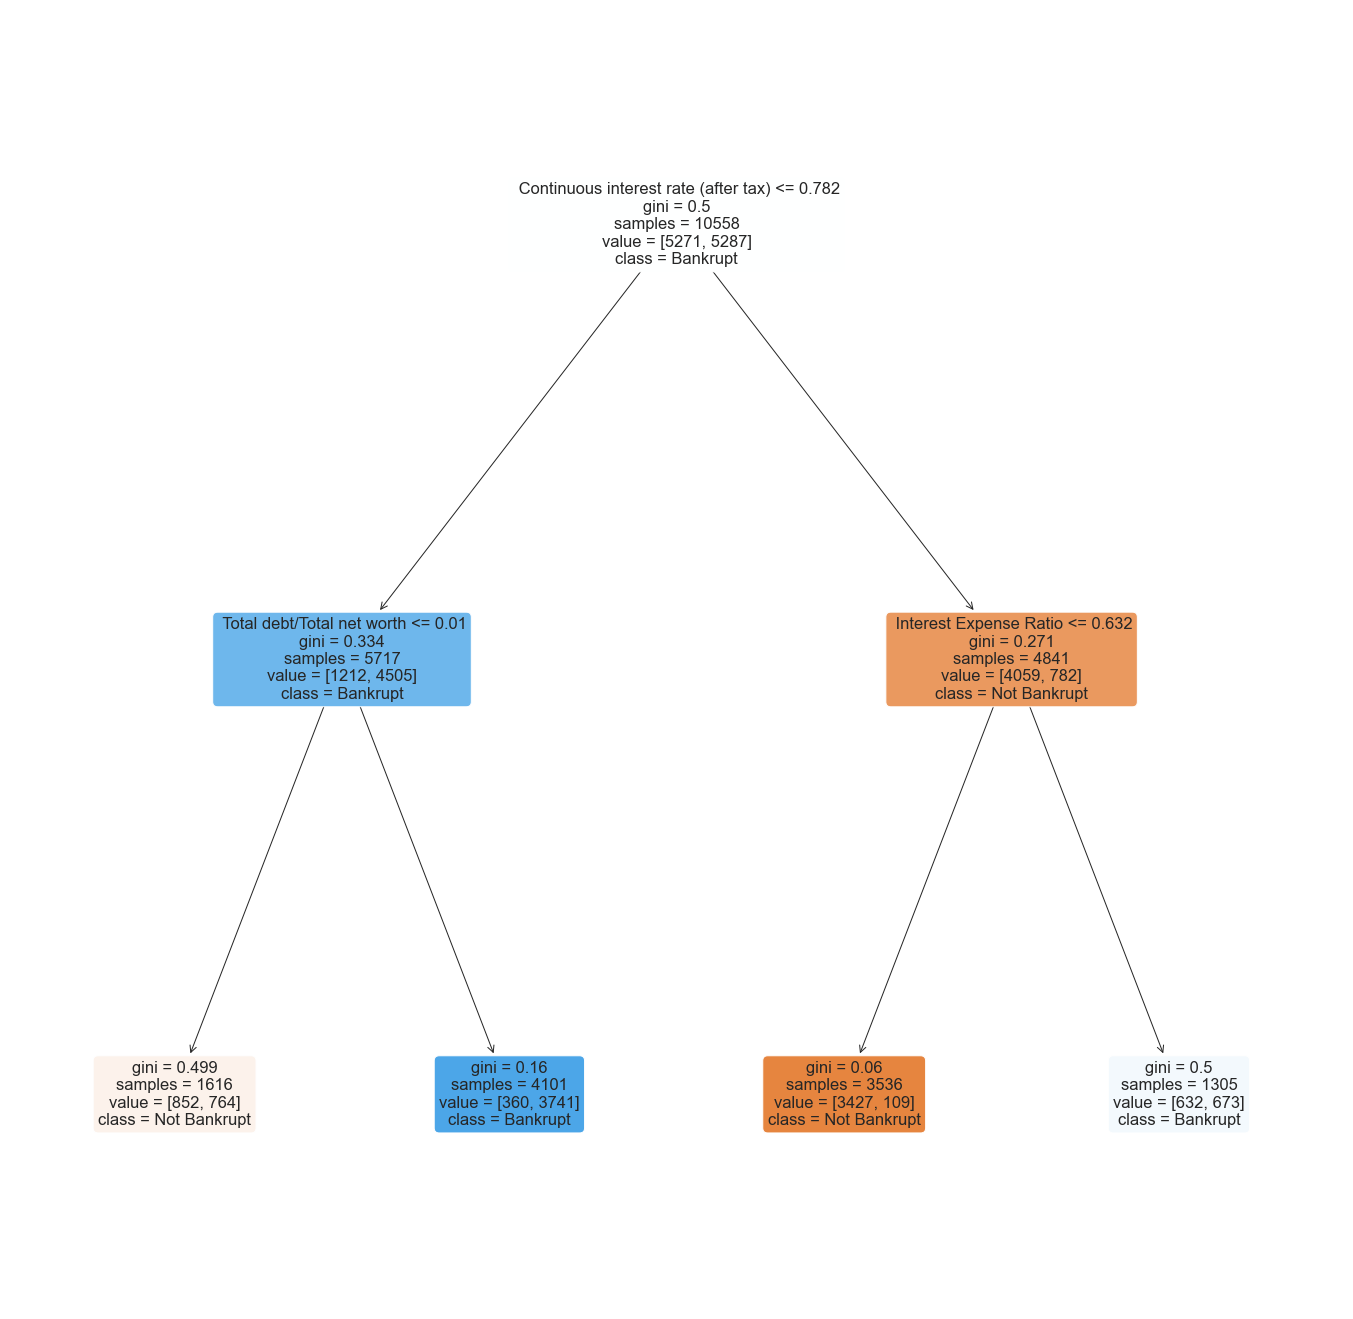

In [144]:
dectree_upsample = DecisionTreeClassifier(max_depth=2)
dectree_upsample.fit(X_train_upsample, y_train_upsample)

f = plt.figure(figsize=(24,24))
plot_tree(dectree_upsample, filled=True, rounded=True, 
          feature_names=X_upsample.columns, 
          class_names=["Not Bankrupt","Bankrupt"])

### Building a Decision Tree Model For Top 10 Variables


[Text(0.5, 0.8333333333333334, ' Persistent EPS in the Last Four Seasons <= 0.213\ngini = 0.5\nsamples = 10558\nvalue = [5271, 5287]\nclass = Bankrupt'),
 Text(0.25, 0.5, ' Debt ratio % <= 0.147\ngini = 0.31\nsamples = 5327\nvalue = [1020, 4307]\nclass = Bankrupt'),
 Text(0.125, 0.16666666666666666, 'gini = 0.5\nsamples = 1311\nvalue = [670, 641]\nclass = Not Bankrupt'),
 Text(0.375, 0.16666666666666666, 'gini = 0.159\nsamples = 4016\nvalue = [350, 3666]\nclass = Bankrupt'),
 Text(0.75, 0.5, ' Net worth/Assets <= 0.827\ngini = 0.304\nsamples = 5231\nvalue = [4251, 980]\nclass = Not Bankrupt'),
 Text(0.625, 0.16666666666666666, 'gini = 0.492\nsamples = 1008\nvalue = [440, 568]\nclass = Bankrupt'),
 Text(0.875, 0.16666666666666666, 'gini = 0.176\nsamples = 4223\nvalue = [3811, 412]\nclass = Not Bankrupt')]

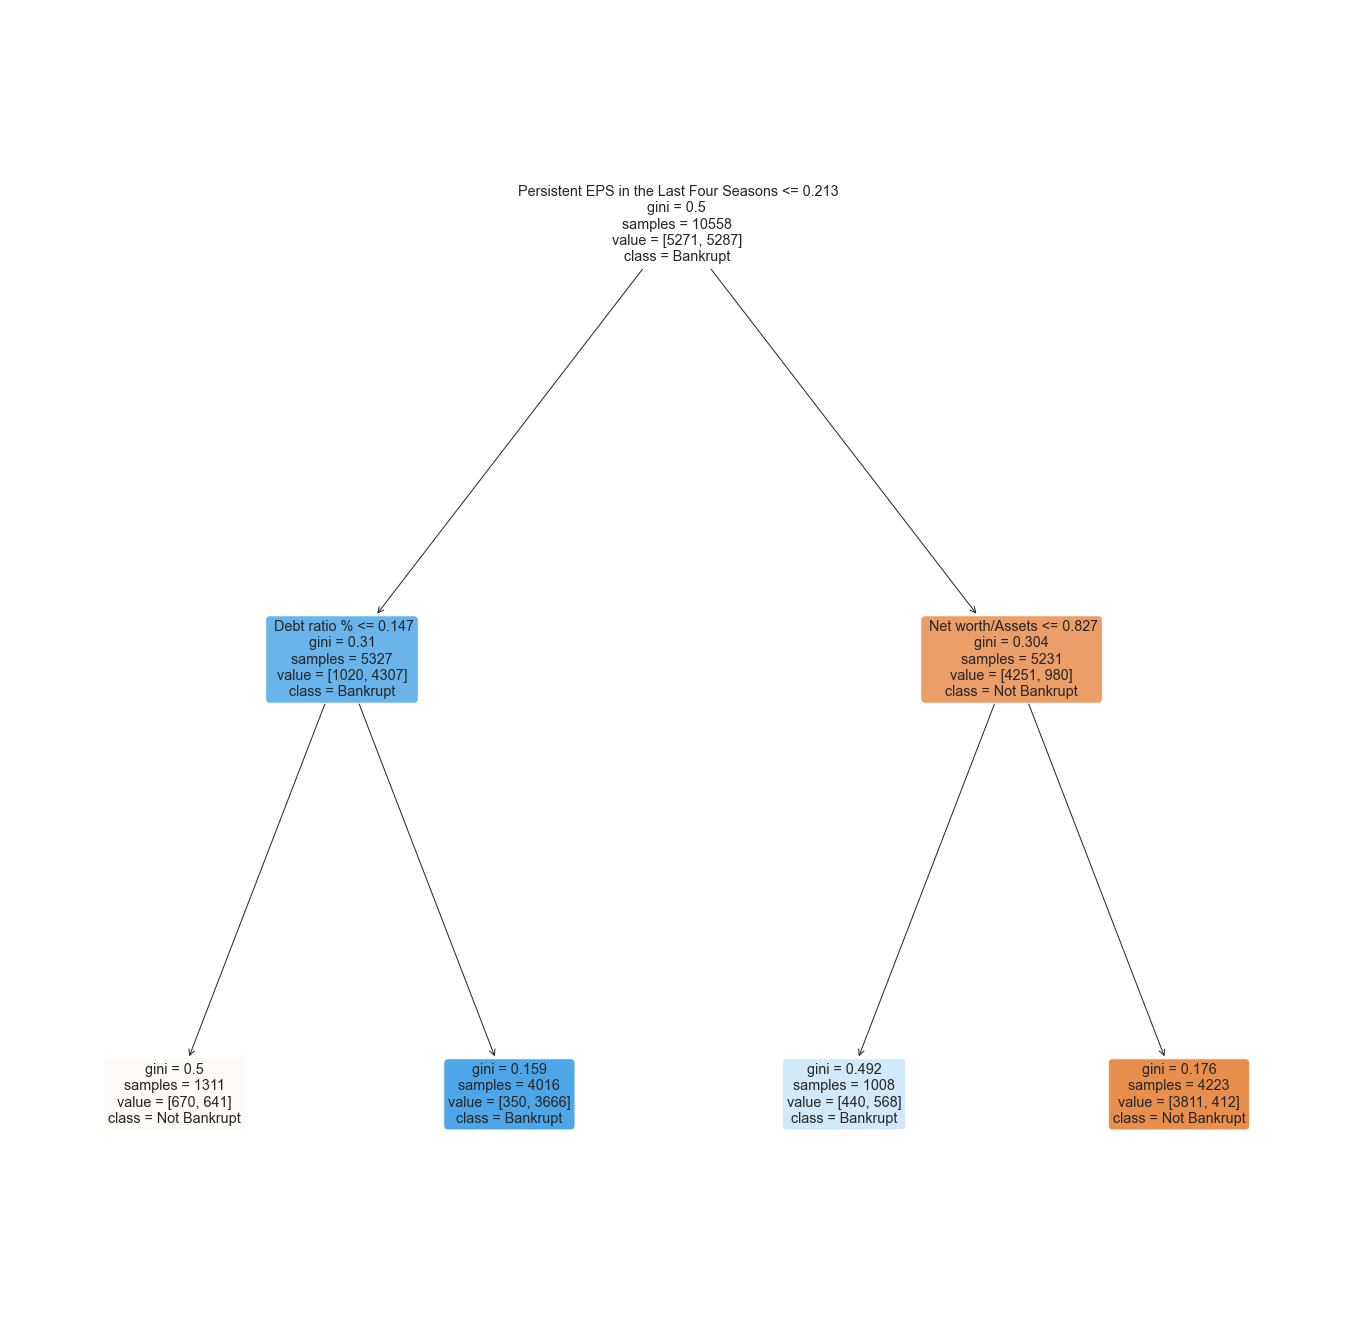

In [145]:
dectree_upsample_top10 = DecisionTreeClassifier(max_depth=2)
dectree_upsample_top10.fit(X_train_top10_upsample, y_train_top10_upsample)

f = plt.figure(figsize=(24,24))
plot_tree(dectree_upsample_top10, filled=True, rounded=True, 
          feature_names=X_top10_upsample.columns, 
          class_names=["Not Bankrupt","Bankrupt"])

### Seeing the accuracy of our Decision Tree Model

### The code below calculates th accuracy of our Decision Tree Model of depth 2 for all variables as well as the top 10 variables.

In [184]:
# Evaluate the accuracy of the model for all upsampled variables
y_pred_upsample = dectree_upsample.predict(X_test_upsample)

accuracy = accuracy_score(y_test_upsample, y_pred_upsample)
print("Accuracy of the model with all varaibles: {:.2f}%".format(accuracy*100))


# Evaluate the accuracy of the model for top 10 upsampled variables
y_pred_upsample_top10 = dectree_upsample_top10.predict(X_test_top10_upsample)

accuracy = accuracy_score(y_test_top10_upsample, y_pred_upsample_top10)
print("Accuracy of the model with top 10 variables: {:.2f}%".format(accuracy*100))


Accuracy of the model with all varaibles: 82.61%
Accuracy of the model with top 10 variables: 82.80%


### Calculating multiple accuracy values for our two decision tree models from a range of depth = 1 to depth = 10

In [175]:
# For top 95 upsampled
for i in range(1,10):
    dectree = DecisionTreeClassifier(max_depth=i)
    dectree.fit(X_train_upsample, y_train_upsample)
    y_pred_upsample = dectree.predict(X_test_upsample)
    accuracy = accuracy_score(y_test_upsample, y_pred_upsample)
    print(f"Accuracy of the model for all variables for tree of depth {i}: {accuracy*100:.2f}%")
print("----------")


# For top 10 upsampled
for i in range(1,10):
    dectree = DecisionTreeClassifier(max_depth=i)
    dectree.fit(X_train_top10_upsample, y_train_top10_upsample)
    y_pred_upsample_top10 = dectree.predict(X_test_top10_upsample)
    accuracy_top10 = accuracy_score(y_test_top10_upsample, y_pred_upsample_top10)
    print(f"Accuracy of the model for top 10 variables for tree of depth {i}: {accuracy_top10*100:.2f}%")
print("----------")


Accuracy of the model for all variables for tree of depth 1: 80.80%
Accuracy of the model for all variables for tree of depth 2: 82.61%
Accuracy of the model for all variables for tree of depth 3: 89.24%
Accuracy of the model for all variables for tree of depth 4: 92.39%
Accuracy of the model for all variables for tree of depth 5: 94.39%
Accuracy of the model for all variables for tree of depth 6: 95.80%
Accuracy of the model for all variables for tree of depth 7: 96.10%
Accuracy of the model for all variables for tree of depth 8: 96.44%
Accuracy of the model for all variables for tree of depth 9: 96.70%
----------
Accuracy of the model for top 10 variables for tree of depth 1: 80.83%
Accuracy of the model for top 10 variables for tree of depth 2: 82.80%
Accuracy of the model for top 10 variables for tree of depth 3: 87.73%
Accuracy of the model for top 10 variables for tree of depth 4: 88.18%
Accuracy of the model for top 10 variables for tree of depth 5: 90.72%
Accuracy of the model 

### We then plot a graph to visualise how the accuracy changes as the depth increases

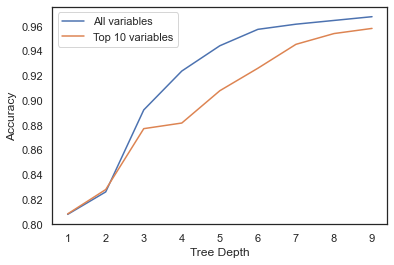

In [176]:

depths = range(1, 10)
accuracies = []
accuracies_top10 = []

# For top 95 upsampled
for i in depths:
    dectree = DecisionTreeClassifier(max_depth=i)
    dectree.fit(X_train_upsample, y_train_upsample)
    y_pred_upsample = dectree.predict(X_test_upsample)
    accuracy = accuracy_score(y_test_upsample, y_pred_upsample)
    accuracies.append(accuracy)

# For top 10 upsampled
for i in depths:
    dectree = DecisionTreeClassifier(max_depth=i)
    dectree.fit(X_train_top10_upsample, y_train_top10_upsample)
    y_pred_upsample_top10 = dectree.predict(X_test_top10_upsample)
    accuracy_top10 = accuracy_score(y_test_top10_upsample, y_pred_upsample_top10)
    accuracies_top10.append(accuracy_top10)

# Plot the accuracy versus depth for both models
plt.plot(depths, accuracies, label='All variables')
plt.plot(depths, accuracies_top10, label='Top 10 variables')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### We then prune the trees from the max depth of 10 to determine at which point does overfitting occur. Pruning the tree allows us to determine the level at which accuracy of the model is maximised without overfitting the data

In [179]:
# Split the data into training and validation sets for all variables
X_train, X_val, y_train, y_val = train_test_split(X_train_upsample, y_train_upsample, test_size=0.2, random_state=42)

# Train the decision tree with a high value of max_depth
dectree = DecisionTreeClassifier(max_depth=10)
dectree.fit(X_train, y_train)

# Evaluate the performance of the decision tree on the validation set
y_pred_val = dectree.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"Accuracy of the model on the validation set: {accuracy_val*100:.2f}%")

# Reduce the depth of the tree until the performance on the validation set starts to decrease
while True:
    depth = dectree.get_depth()
    if depth == 1:
        break
    dectree = DecisionTreeClassifier(max_depth=depth-1)
    dectree.fit(X_train, y_train)
    y_pred_val = dectree.predict(X_val)
    accuracy_val_new = accuracy_score(y_val, y_pred_val)
    if accuracy_val_new < accuracy_val:
        break
    accuracy_val = accuracy_val_new

# The depth of the pruned decision tree
optimal_depth_all = dectree.get_depth()
print(f"Optimal depth of the pruned tree for all variables: {optimal_depth_all}")

Accuracy of the model on the validation set: 97.49%
Optimal depth of the pruned tree for all variables: 9


In [180]:
# Split the data into training and validation sets for top 10 variables
X_train, X_val, y_train, y_val = train_test_split(X_train_top10_upsample, y_train_top10_upsample, test_size=0.2, random_state=42)

# Train the decision tree with a high value of max_depth
dectree = DecisionTreeClassifier(max_depth=10)
dectree.fit(X_train, y_train)

# Evaluate the performance of the decision tree on the validation set
y_pred_val = dectree.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"Accuracy of the model on the validation set: {accuracy_val*100:.2f}%")

# Reduce the depth of the tree until the performance on the validation set starts to decrease
while True:
    depth = dectree.get_depth()
    if depth == 1:
        break
    dectree = DecisionTreeClassifier(max_depth=depth-1)
    dectree.fit(X_train, y_train)
    y_pred_val = dectree.predict(X_val)
    accuracy_val_new = accuracy_score(y_val, y_pred_val)
    if accuracy_val_new < accuracy_val:
        break
    accuracy_val = accuracy_val_new

# The depth of the pruned decision tree
optimal_depth_top10 = dectree.get_depth()
print(f"Optimal depth of the pruned tree for top 10 variables: {optimal_depth_top10}")

Accuracy of the model on the validation set: 96.69%
Optimal depth of the pruned tree for top 10 variables: 9


### This code block below plots the AUC and its associated classification report for the NN model on all variables.

83/83 [==============================] - 0s 2ms/step


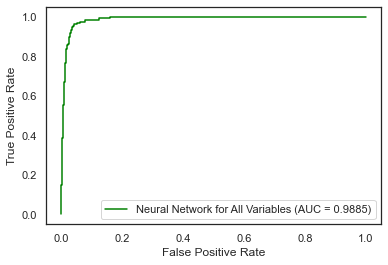

83/83 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.9819    0.8983    0.9383      1328
           1     0.9053    0.9832    0.9426      1312

    accuracy                         0.9405      2640
   macro avg     0.9436    0.9408    0.9404      2640
weighted avg     0.9438    0.9405    0.9404      2640

83/83 [==============================] - 0s 1ms/step - loss: 0.1455 - accuracy: 0.9405
Test accuracy: 0.9405303001403809


In [188]:


# predict probabilities with neural network model for all variables
nn_probs = model_upsample_all.predict(X_test_upsample)
# compare the predicted probabilities
fpr_nn, tpr_nn, _ = roc_curve(y_test_upsample, nn_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)
plt.plot(fpr_nn, tpr_nn, color='green', label='Neural Network for All Variables (AUC = %0.4f)' % roc_auc_nn)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Predict on test data
y_pred = model_upsample_all.predict(X_test_upsample)

# Convert predicted probabilities to class labels
y_pred = (y_pred > 0.5).astype(int)

# Generate classification report
print(classification_report(y_test_upsample, y_pred, digits = 4))

loss, accuracy = model_upsample_all.evaluate(X_test_upsample, y_test_upsample)
print('Test accuracy:', accuracy)



### This code block below plots the AUC and its associated classification report for the NN model on the top 10 variables.

83/83 [==============================] - 0s 1ms/step


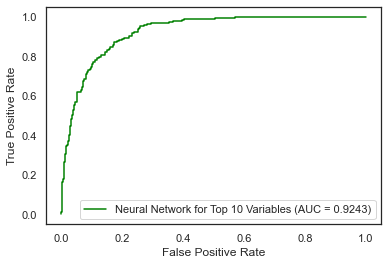

83/83 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.8090    0.8773    0.8418      1328
           1     0.8642    0.7904    0.8256      1312

    accuracy                         0.8341      2640
   macro avg     0.8366    0.8338    0.8337      2640
weighted avg     0.8364    0.8341    0.8337      2640

83/83 [==============================] - 0s 1ms/step - loss: 0.4761 - accuracy: 0.8341
Test accuracy: 0.8340908885002136


In [189]:
# predict probabilities with neural network model for top 10 variables
nn_probs_top10 = model_upsample_top10.predict(X_test_top10_upsample)
# compare the predicted probabilities
fpr_nn_top10, tpr_nn_top10, _ = roc_curve(y_test_top10_upsample, nn_probs_top10)
roc_auc_nn_top10 = auc(fpr_nn_top10, tpr_nn_top10)
plt.plot(fpr_nn_top10, tpr_nn_top10, color='green', label='Neural Network for Top 10 Variables (AUC = %0.4f)' % roc_auc_nn_top10)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Predict on test data
y_pred = model_upsample_top10.predict(X_test_top10_upsample)

# Convert predicted probabilities to class labels
y_pred = (y_pred > 0.5).astype(int)

# Generate classification report
print(classification_report(y_test_top10_upsample, y_pred, digits = 4))

loss, accuracy = model_upsample_top10.evaluate(X_test_top10_upsample, y_test_top10_upsample)
print('Test accuracy:', accuracy)




### This code block below plots the AUC and its associated classification report for the Decision Tree model on all variables.

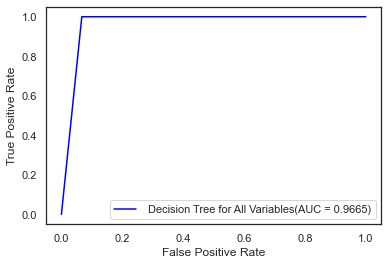

              precision    recall  f1-score   support

           0     1.0000    0.9330    0.9653      1328
           1     0.9365    1.0000    0.9672      1312

    accuracy                         0.9663      2640
   macro avg     0.9682    0.9665    0.9663      2640
weighted avg     0.9684    0.9663    0.9663      2640



In [190]:

# create decision tree model and fit to training data for all variables

dt_model = DecisionTreeClassifier(max_depth=optimal_depth_all)
dt_model.fit(X_train_upsample, y_train_upsample)
# predict probabilities with decision tree model
dt_probs = dt_model.predict(X_test_upsample)


fpr_dt, tpr_dt, _ = roc_curve(y_test_upsample, dt_probs)

roc_auc_dt = auc(fpr_dt, tpr_dt)


plt.plot(fpr_dt, tpr_dt, color='blue', label=' Decision Tree for All Variables(AUC = %0.4f)' % roc_auc_dt)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


# Generate the classification report
print(classification_report(y_test_upsample, dt_probs, digits = 4))


### This code block below plots the AUC and its associated classification report for the decision tree model on the top 10 variables.

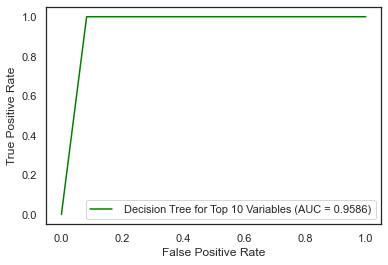

              precision    recall  f1-score   support

           0     1.0000    0.9172    0.9568      1328
           1     0.9226    1.0000    0.9598      1312

    accuracy                         0.9583      2640
   macro avg     0.9613    0.9586    0.9583      2640
weighted avg     0.9616    0.9583    0.9583      2640



In [192]:

# create decision tree model and fit to training data for top 10 variables

dt_model_top10 = DecisionTreeClassifier(max_depth=optimal_depth_top10)
dt_model_top10.fit(X_train_top10_upsample, y_train_top10_upsample)
# predict probabilities with decision tree model
dt_probs_top10 = dt_model_top10.predict(X_test_top10_upsample)

fpr_dt_top10, tpr_dt_top10, _ = roc_curve(y_test_top10_upsample, dt_probs_top10)

roc_auc_dt_top10 = auc(fpr_dt_top10, tpr_dt_top10)

plt.plot(fpr_dt_top10, tpr_dt_top10, color='green', label=' Decision Tree for Top 10 Variables (AUC = %0.4f)' % roc_auc_dt_top10)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Generate the classification report
print(classification_report(y_test_top10_upsample, dt_probs_top10, digits = 4))



### This code block below plots the 4 graphs above into one plot to visualise the differences (Jing Xuan you can add your model below here as well)

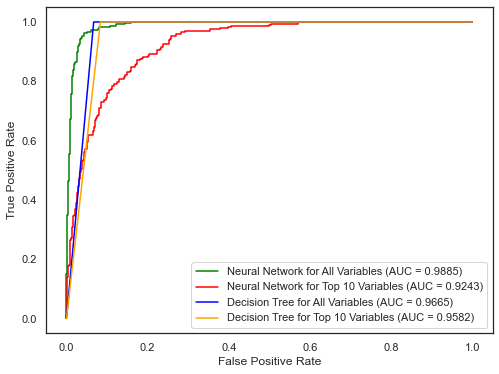

In [186]:

# plot the combined ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='green', label='Neural Network for All Variables (AUC = %0.4f)' % roc_auc_nn)
plt.plot(fpr_nn_top10, tpr_nn_top10, color='red', label='Neural Network for Top 10 Variables (AUC = %0.4f)' % roc_auc_nn_top10)
plt.plot(fpr_dt, tpr_dt, color='blue', label='Decision Tree for All Variables (AUC = %0.4f)' % roc_auc_dt)
plt.plot(fpr_dt_top10, tpr_dt_top10, color='orange', label='Decision Tree for Top 10 Variables (AUC = %0.4f)' % roc_auc_dt_top10)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


### This code block below plots the 4 graphs above into separate plots for further visualisation (Jing Xuan you can add your models below as well)

83/83 [==============================] - 0s 1ms/step


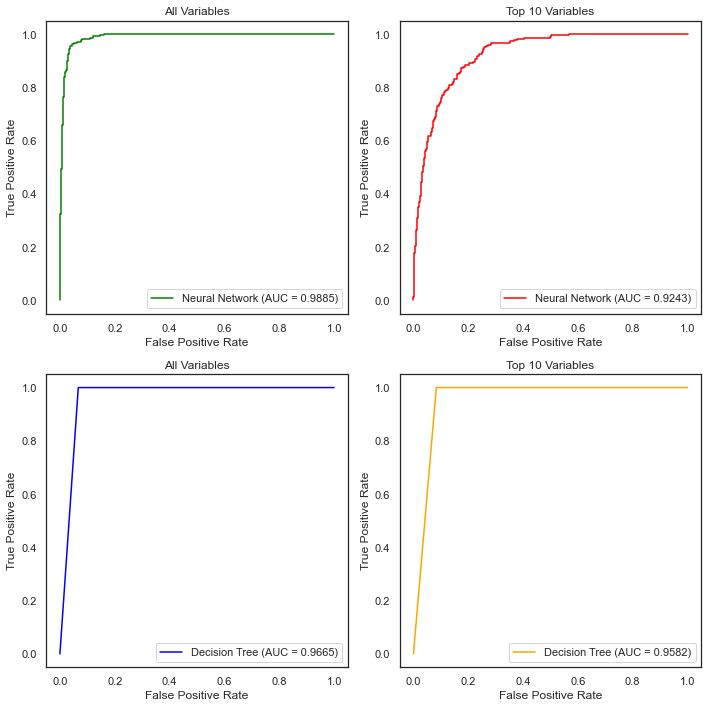

In [187]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# plot ROC curve for neural network with all variables
nn_probs = model_upsample_all.predict(X_test_upsample)
fpr_nn, tpr_nn, _ = roc_curve(y_test_upsample, nn_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)
axes[0, 0].plot(fpr_nn, tpr_nn, color='green', label='Neural Network (AUC = %0.4f)' % roc_auc_nn)
axes[0, 0].set_title('All Variables')

# plot ROC curve for neural network with top 10 variables
nn_probs_top10 = model_upsample_top10.predict(X_test_top10_upsample)
fpr_nn_top10, tpr_nn_top10, _ = roc_curve(y_test_top10_upsample, nn_probs_top10)
roc_auc_nn_top10 = auc(fpr_nn_top10, tpr_nn_top10)
axes[0, 1].plot(fpr_nn_top10, tpr_nn_top10, color='red', label='Neural Network (AUC = %0.4f)' % roc_auc_nn_top10)
axes[0, 1].set_title('Top 10 Variables')

# plot ROC curve for decision tree with all variables
fpr_dt, tpr_dt, _ = roc_curve(y_test_upsample, dt_probs)
roc_auc_dt = auc(fpr_dt, tpr_dt)
axes[1, 0].plot(fpr_dt, tpr_dt, color='blue', label='Decision Tree (AUC = %0.4f)' % roc_auc_dt)
axes[1, 0].set_title('All Variables')

# plot ROC curve for decision tree with top 10 variables
fpr_dt_top10, tpr_dt_top10, _ = roc_curve(y_test_top10_upsample, dt_probs_top10)
roc_auc_dt_top10 = auc(fpr_dt_top10, tpr_dt_top10)
axes[1, 1].plot(fpr_dt_top10, tpr_dt_top10, color='orange', label='Decision Tree (AUC = %0.4f)' % roc_auc_dt_top10)
axes[1, 1].set_title('Top 10 Variables')

# add axis labels and legends
for ax in axes.flat:
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

# adjust layout and spacing
fig.tight_layout()
plt.show()
